<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/04_notes_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2023

**Lecture 06**

# Unsupervised learning: k-Means algorithm and clusterization

## recap of intuitions: k-Nearest Neighbors

The whole idea behind the algorithm is to take the $k$-closest points, and pick the label which is the most frequent among them:

<code>
def model.fit(X_train):
    just remember X_train
    
def model.predict(x):
    find samples x_1, x_2,...,x_k in X_train that are closest to x
    return the most frequent label among x_1, ..., x_k
</code>

Just look at the top 20 images closest to `X_tst[22]` to see why it makes sense:

In [8]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

import numpy as np
with np.load('mnist.npz') as data:
    X_trn = data['train_data'][:1000].astype(float)
    y_trn = data['train_labels'][:1000]
    X_tst = data['train_data'][1000:1500].astype(float)
    y_tst = data['train_labels'][1000:1500]


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import matplotlib.pyplot as plt

def plot_digit(x):
    fig = plt.figure(figsize = (2,2))
    plt.imshow(x, cmap='gray')
    plt.show()

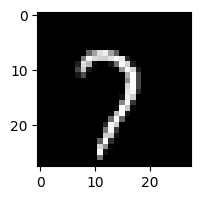

Label: 7


In [10]:
idx_sample = 22
plot_digit(X_tst[idx_sample])
print("Label:", y_tst[idx_sample])

In [11]:
X_tst[idx_sample].shape

(28, 28)

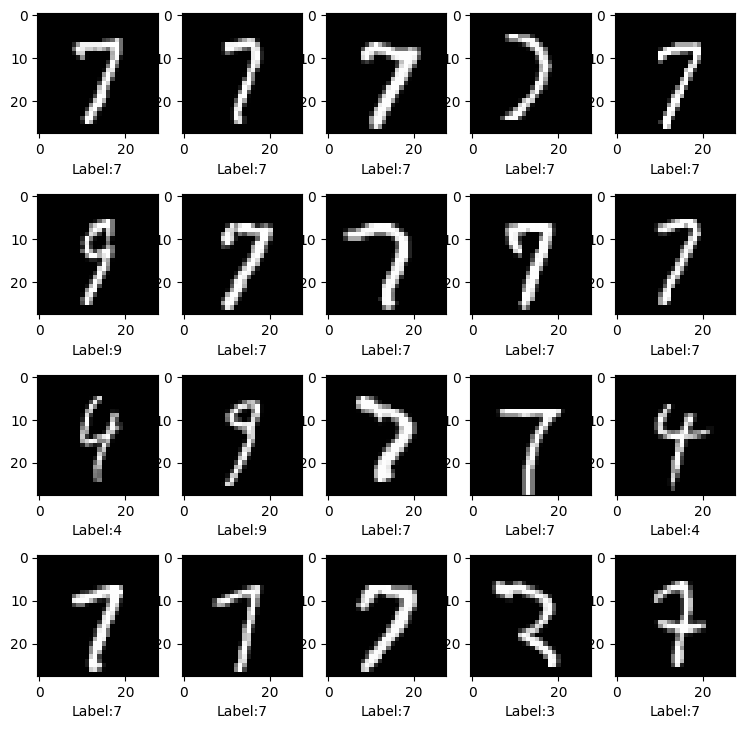

In [12]:
plt.figure(figsize=(9, 9))
i = 0
for idx in ((X_trn - X_tst[idx_sample])**2).sum(axis=(1,2)).argsort()[:20]:
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_trn[idx], cmap='gray')
    plt.xlabel("Label:"+ str(y_trn[idx]))
    i = i + 1

Majority of the numbers in fact is 7 as desired. And for the one which are incorrect you can try to argue that they somehow resemble a 7.

# average images

In [13]:
import numpy as np
with np.load('mnist.npz') as data:
    X_trn = data['train_data'][:10000].astype(float)
    y_trn = data['train_labels'][:10000]
    X_tst = data['train_data'][10000:15000].astype(float)
    y_tst = data['train_labels'][10000:15000]

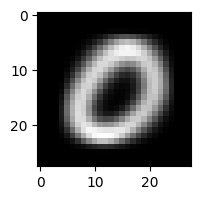

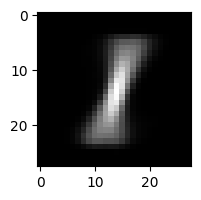

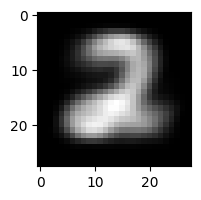

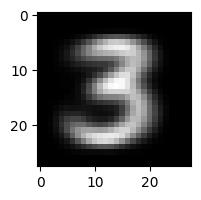

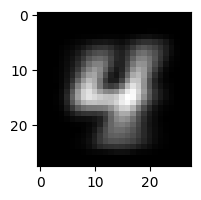

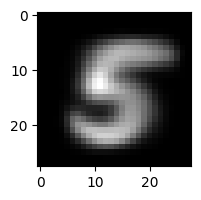

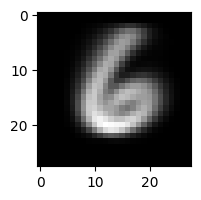

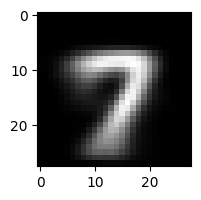

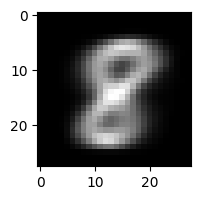

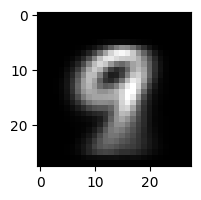

In [14]:
for d in range(10):
    plot_digit(X_trn[y_trn == d].mean(axis=0))

# tsne: why an average image can work?

source: https://www.researchgate.net/figure/Figure-tSNE-embedding-of-the-MNIST-dataset-The-embedded-data-points-are-visualized_fig5_331314858

# kmeans: what is it?

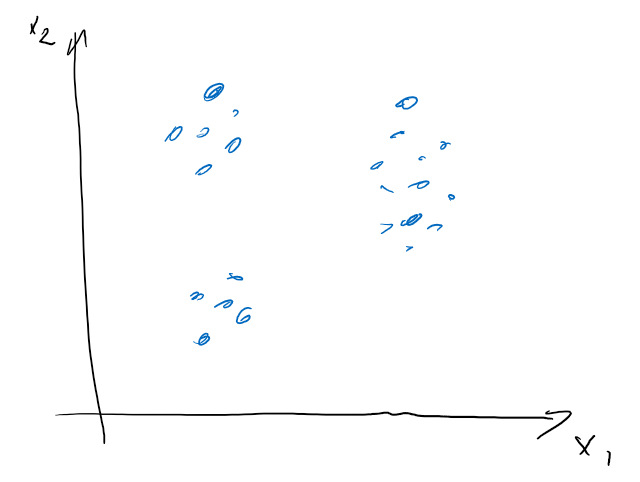

We have a set of 2D points, which have no labels (in the picture they have the same color). However, eyeballing the plot we could say that there are 3 groups of points.

K-Means tries to discover these groups using the following interative approach:

1. Select $K$ seed points (cluster centers)
2. For $N$ iterations:
    1. Assign each datapoint to the nearest center.
    2. Set center of cluster $k$ to the mean of points assigned to $k$.

The algorithm finishes when the assignments stabilize. Intuitively, it discovers a grouping of points such that:
> points in a group are closer to each other, than to points in other groups.

The K-Means algorithm is so basic, that it has been independently developed by many communities. Engineers call it _Vector Quantization_ and interpret it as a lossy compressions scheme, in which each data sample can be replaced with a prototype in a way that minimizes the total sum of errors.

### K-Means as an optimization algorithm

We will now describe formally the task K-Means is solving. Assume a set of $N$ data samples $X = \{x^{(1)}, x^{(2)}, \ldots, x^{(N)}\}$ and choose a desired number of clusters $K$. K-Means finds $K$ cluster *centroids* or *prototypes* $\{\mu^{(j)}, j\in 1,2,\ldots,K\}$. Then, it assigns each sample $x^{(i)}$ to the cluster $c^{(i)} \in \{1, 2, \ldots, K\}$ whose centroids is the closest to $x^{(i)}$: $c^{(i)} = \underset{j}\arg\min ||x^{(i)} - \mu^{(j)}||$. To find the centroids, K-means attempts to solve the following optimization problem:

\begin{equation}
    \underset{\mu, c}{\arg\min} \sum_i||x^{(i)} - \mu^{(c^{(i)})}||^2_2
\end{equation}

We can see that the algorithm given above optimizes this loss iterates between optimizing over $\mu$ and optimizing over $c$:
- Assignement of samples to clusters optimizes over $c$
- Movement of centroids optimizes over $\mu$. 

  In fact $\mu^{(j)} \gets \frac{\sum_i [c^{(i)}=j] x^{(i)}}{\sum_i [c^{(i)}=j]}$, where $[\cdot]$ is the indicator function is the optimal centroid location.


### how does it work?

In [15]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

!pip install imageio
import imageio

from scipy import ndimage
from scipy import stats
from scipy.spatial import distance

from IPython import display


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


/var/folders/jb/f121_ltj0fb06y61hfq9sz5c0000gn/T/ipykernel_11121/2504689333.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(URL)/255.


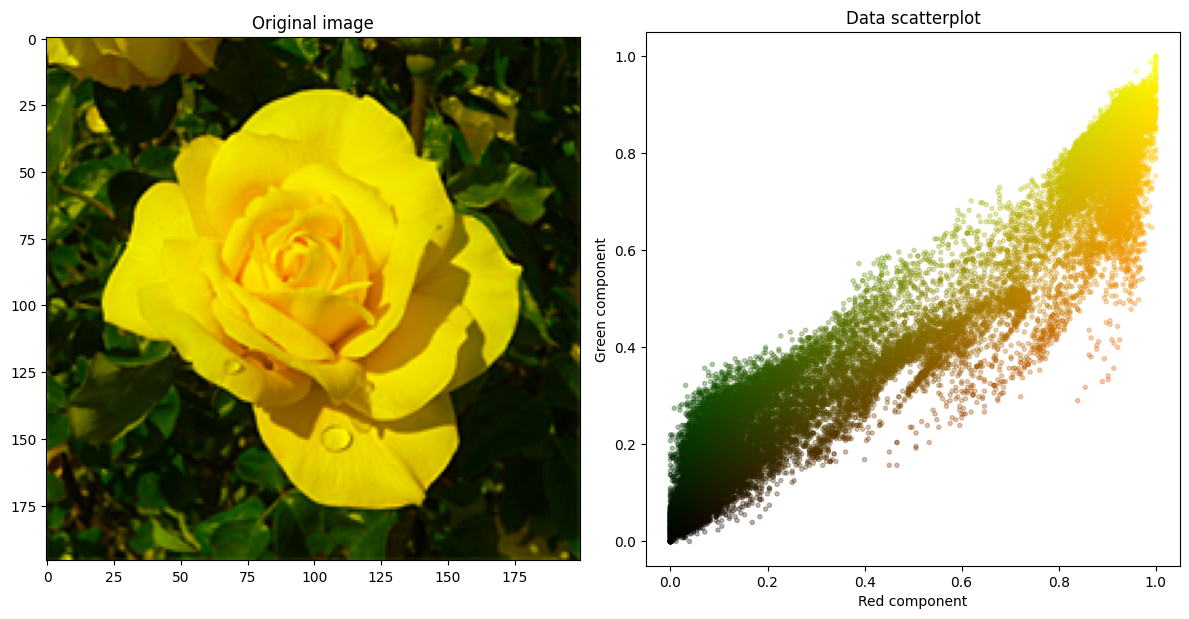

In [16]:
URL = 'https://github.com/janchorowski/nn_assignments/raw/nn17_fall/lecture_notebooks/11-Rosa_Gold_Glow_2_small_noblue.png'
img = imageio.imread(URL)/255.

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.title('Original image')
im_flat = img.reshape([-1, 3])
plt.subplot(122)
plt.title('Data scatterplot')
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.xlabel('Red component')
plt.ylabel('Green component')
plt.axis('square')
plt.tight_layout()
None

In [17]:
N, D = im_flat.shape

Iteration: 0 Loss: 46.6952


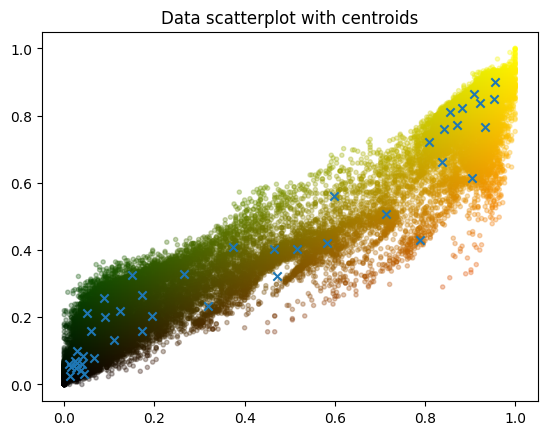

Iteration: 10 Loss: 32.6165


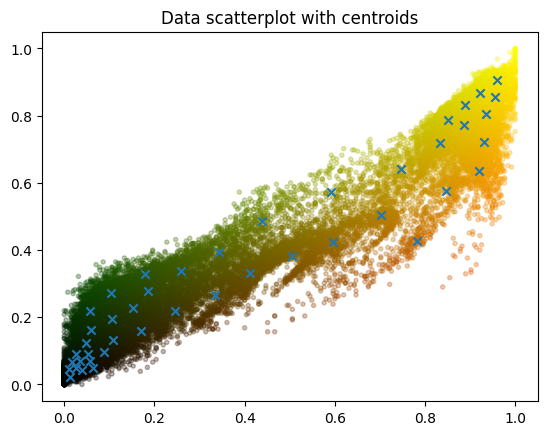

Iteration: 20 Loss: 31.5683


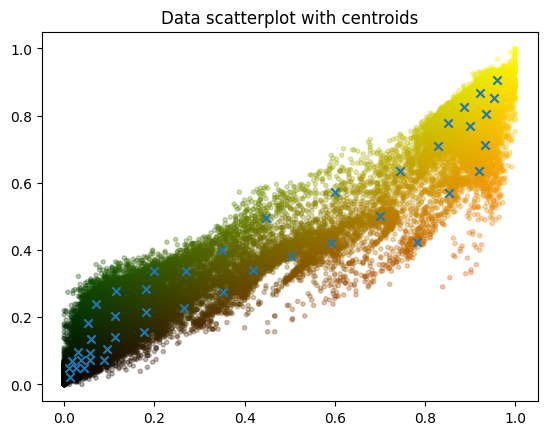

Iteration: 30 Loss: 30.8356


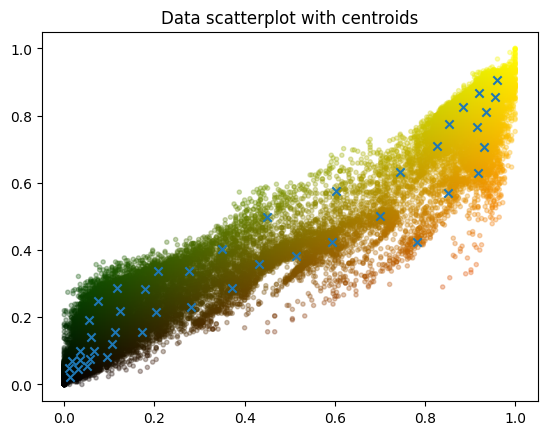

Iteration: 40 Loss: 30.2707


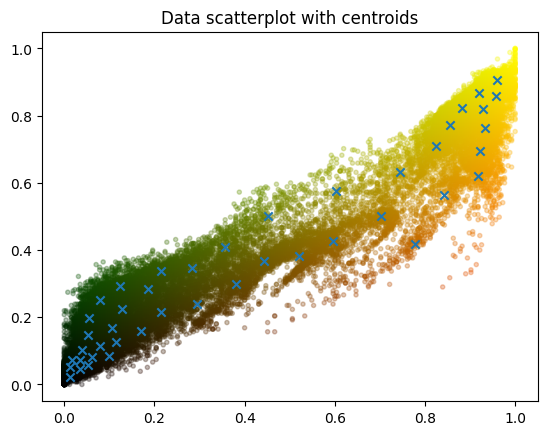

Iteration: 50 Loss: 29.7487


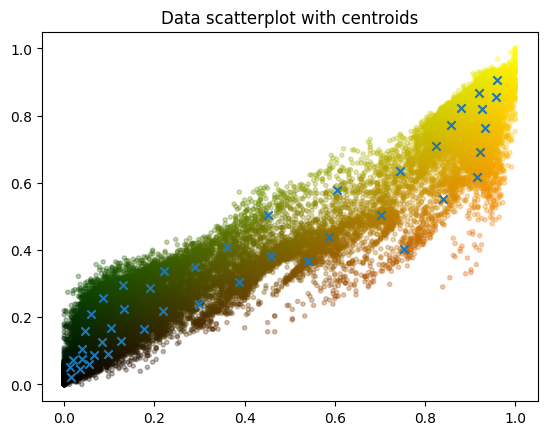

Iteration: 60 Loss: 29.4654


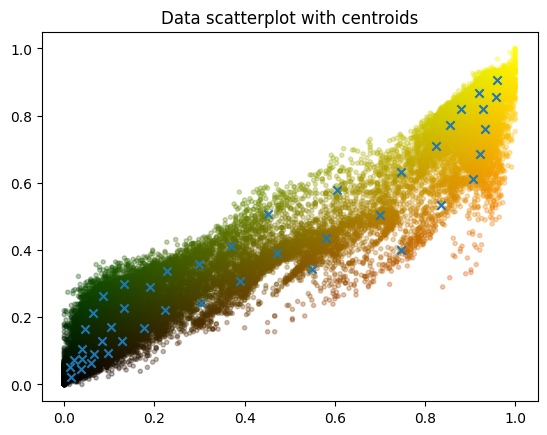

Iteration: 70 Loss: 29.3388


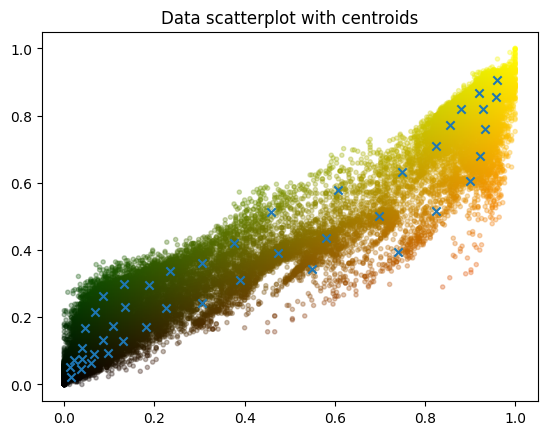

Iteration: 80 Loss: 29.2164


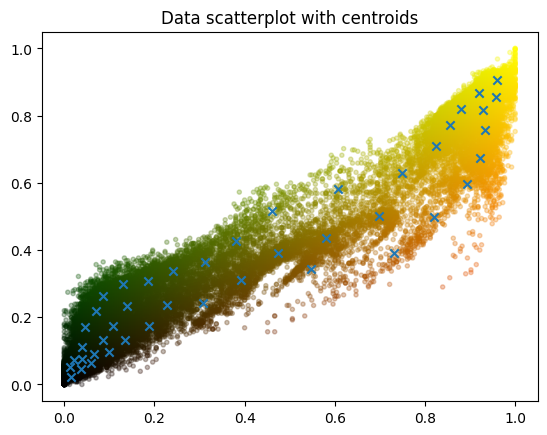

Iteration: 90 Loss: 29.0168


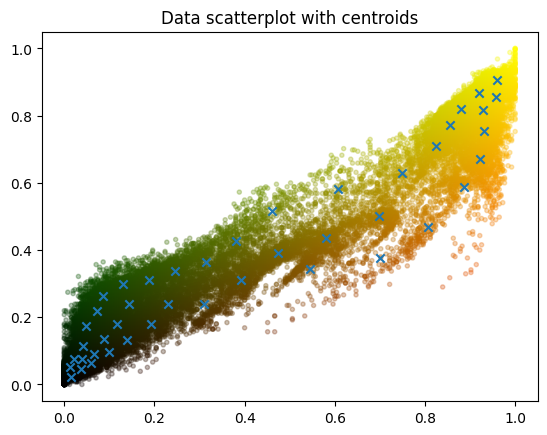

Iteration: 100 Loss: 28.8458


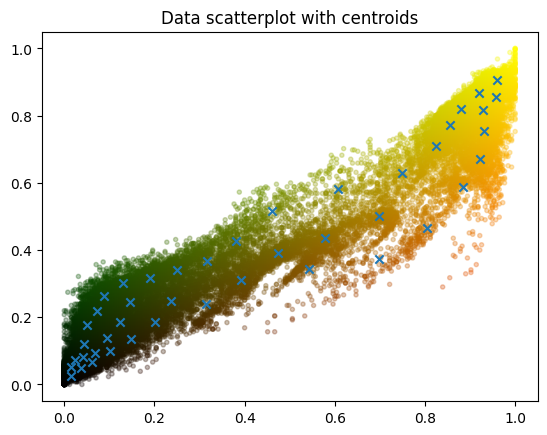

Iteration: 110 Loss: 28.7735


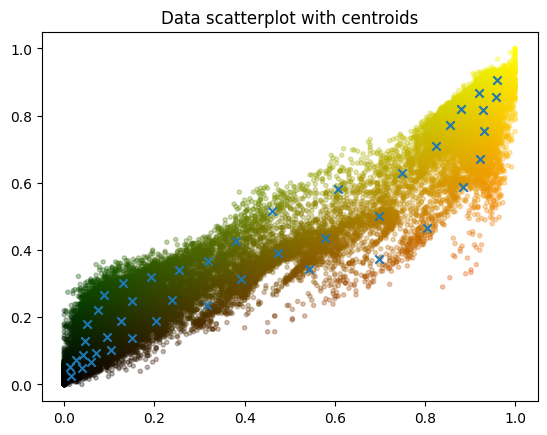

Iteration: 120 Loss: 28.7235


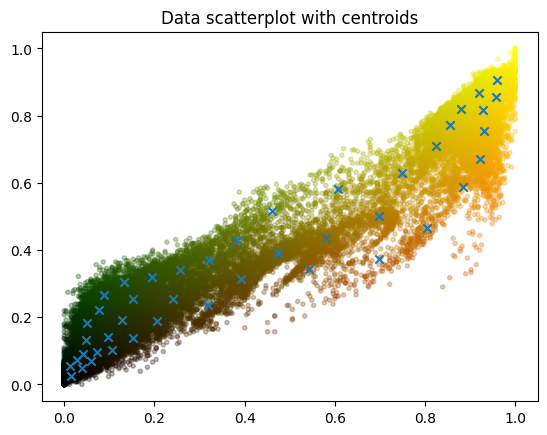

Iteration: 130 Loss: 28.6384


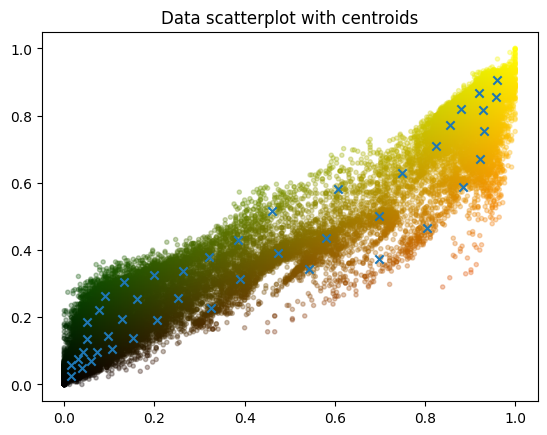

Iteration: 140 Loss: 28.558


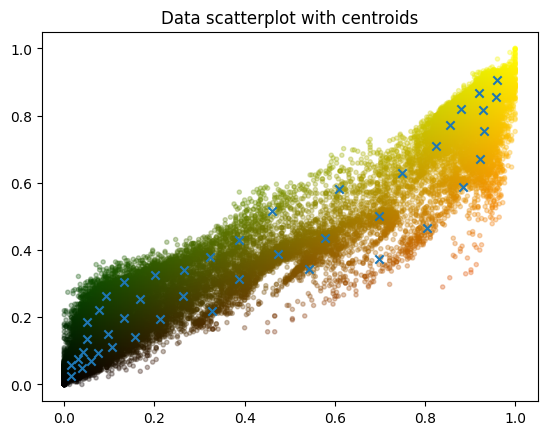

Iteration: 150 Loss: 28.4781


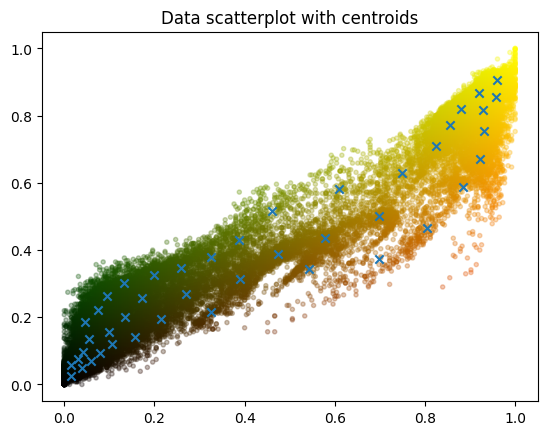

Iteration: 160 Loss: 28.4335


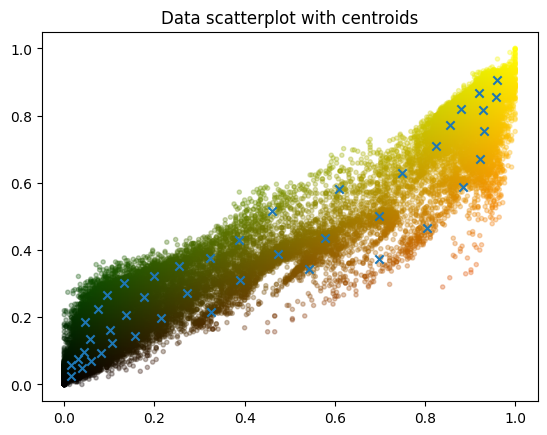

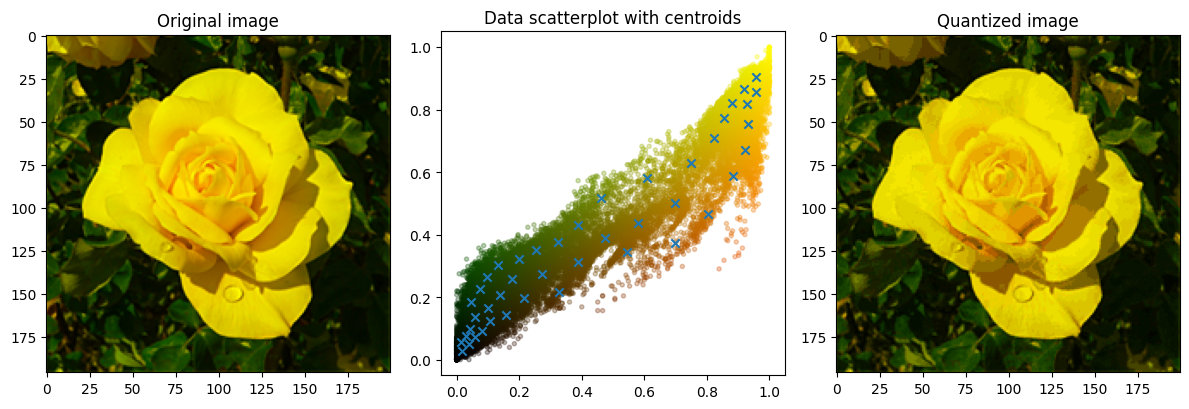

In [18]:
K = 44
initial_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initial_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in range(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
        plt.title('Data scatterplot with centroids')
        plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
        plt.scatter(centers[:,0], centers[:,1], marker='x')
        plt.show()
    if loss >= old_loss:
        break
    old_loss = loss

        

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original image')
plt.imshow(img)
plt.grid(False)

plt.subplot(132)
plt.title('Data scatterplot with centroids')
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.title('Quantized image')
plt.imshow(centers[cluster_assignment].reshape(img.shape))
plt.grid(False)
plt.tight_layout()

# kmeans on MNIST

In [19]:
import numpy as np
with np.load('mnist.npz') as data:
    X_trn = data['train_data'][:10000].astype(float)
    y_trn = data['train_labels'][:10000]
    X_tst = data['train_data'][10000:15000].astype(float)
    y_tst = data['train_labels'][10000:15000]

In [20]:
from sklearn.cluster import KMeans

k=10
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_trn.reshape(-1,28*28))
kmeans.labels_ 

/Users/marek-ext/MOJE/ml_uwr_23/.ml_venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 1, 7, ..., 8, 0, 2], dtype=int32)

In [21]:
kmeans.labels_.shape

(10000,)

**Using k-Means for classification can be a bad idea:**

Cluster number: 0


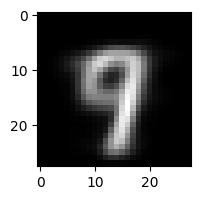

7    380
9    375
4    246
5     63
8     43
3     35
2      7
0      2
1      2
6      1
Name: count, dtype: int64
Cluster number: 1


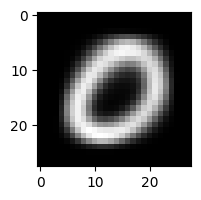

0    778
6     14
5      9
2      7
3      6
9      5
8      4
7      1
Name: count, dtype: int64
Cluster number: 2


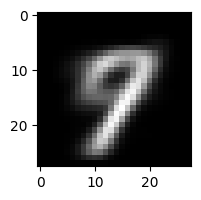

7    494
9    312
4    258
8     25
5     21
3      8
2      3
0      1
1      1
Name: count, dtype: int64
Cluster number: 3


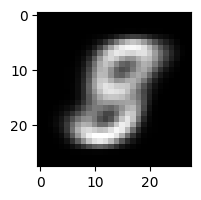

8    471
5    306
3    241
0    111
2     25
6     16
1      2
9      2
4      1
Name: count, dtype: int64
Cluster number: 4


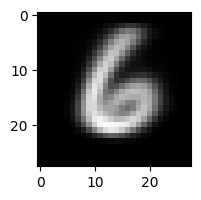

6    781
0     36
2     28
5     21
4     16
8     16
3      9
9      3
1      1
Name: count, dtype: int64
Cluster number: 5


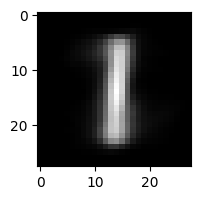

1    544
2     78
3     69
6     52
8     48
7     27
5     19
4     16
9     10
0      1
Name: count, dtype: int64
Cluster number: 6


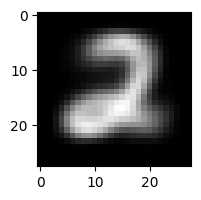

2    655
3     24
6      8
8      6
7      5
0      5
4      3
5      2
1      2
Name: count, dtype: int64
Cluster number: 7


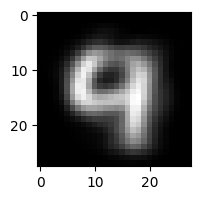

4    397
9    241
7    114
6    100
5     28
8     25
0     21
2     21
3      8
Name: count, dtype: int64
Cluster number: 8


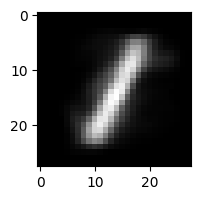

1    573
5    157
2    103
8     79
7     48
4     43
6     37
3     16
9     13
Name: count, dtype: int64
Cluster number: 9


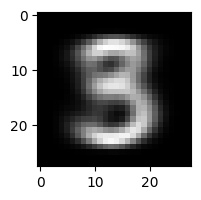

3    616
5    237
8    227
2     64
0     46
9     17
6      5
1      2
7      1
Name: count, dtype: int64


In [25]:
import pandas as pd

for i in range(k):
    print(f"Cluster number: {i}")
    plot_digit(X_trn[kmeans.labels_ == i].mean(axis=0))
    print(pd.Series(y_trn[kmeans.labels_ == i]).value_counts())
    